# Data Scientist Professional Case Study

### Company Background

Inn the Neighborhood is an online platform that allows people to rent out their properties for short stays. At the moment, only 2% of people who come to the site interested in renting out their homes start to use it.

The product manager would like to increase this. They want to develop an application to help people estimate how much they could earn renting out their living space. They hope that this would make people more likely to sign up.



### Customer Question

The product manager would like to know:
- Can you develop a way to predict how much someone could earn from renting their property that could power the application?




### Success Criteria

They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.


### Dataset

The data you will use for this analysis can be accessed here: `"data/rentals.csv"`

# Data Validation and Cleaning

This data set contains 8111 row and 9 columns of data. I am going to check the data set for NaN values and do some data cleansing.  

All columns are as described in the data dictionary.

- id: numeric
- latitude: numeric
- longitude: numeric
- property_type: categorical, 26 possible values
- room_type: categorical, 4 possible values
- bathrooms: numeric
- bedrooms: numeric
- minimum_nights: numeric
- price: numeric

In [683]:
# Importing necessary modules for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Setting stype for graphs
sns.set_style("darkgrid")

# Setting random seed for reproducibility
random_state = 23

In [627]:
# Loading in dataset and printing information
df = pd.read_csv('data/rentals.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB
None
     id  latitude  longitude property_type        room_type  bathrooms  \
0   958  37.76931 -122.43386     Apartment  Entire home/apt        1.0   
1  3850  37.75402 -122.45805         House     Private room        1.0   
2  5858  37.74511 -122.42102     Apartment  Entire home/apt        1.0   
3  7918  37.76669 -122.45250     A

The bathrooms and bedroom columns have nonmissing values. I am going to check the percentage the missing values make up the whole column.

In [628]:
# Checking bathroom column
print(df['bathrooms'].isna().sum()/(len(df['bathrooms'])) * 100)

0.14794723215386513


In [629]:
# Checking bedroom column
print(df['bedrooms'].isna().sum()/(len(df['bedrooms'])) * 100)

0.04931574405128837


NaN rows only make up 0.148% and 0.049% of the bathroom and bedroom columns respectively. This is a insignificant amount of data that is missing. We will just fill the NaN values with the median value in those columns.

In [630]:
# Filling NaN values
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)

In [631]:
# Checking for missing NaN values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8111 non-null   float64
 6   bedrooms        8111 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB
None


### Validating values in categorical columns.

There are two categorical columns in our data: Property Type and Room Type. I am going to validate the values located in these columns to check for duplicates and values that maybe similar to other values. 

- Property Type: 26 different values
- Room Type: 4 different values

In [632]:
# Validating values property_type column
df['property_type'].unique()

array(['Apartment', 'House', 'Condominium', 'Townhouse', 'Loft',
       'Guest suite', 'Cottage', 'Hostel', 'Guesthouse',
       'Serviced apartment', 'Bungalow', 'Bed and breakfast', 'Hotel',
       'Boutique hotel', 'Other', 'Tiny house', 'Resort', 'Villa',
       'Aparthotel', 'Castle', 'Camper/RV', 'In-law', 'Earth house',
       'Cabin', 'Dome house', 'Hut'], dtype=object)

In [633]:
# Validating values property_type column
df['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

### Validation of Object Price Column

Since the price column is currently an object type, we will want to convert it to a float64 object since the price contains decimals.

In [634]:
# Converting price column to numeric
# Striping '$' and ','
df['price'] = df['price'].str.replace('[\$\,]', '').astype(float)
print(df['price'].head())

0    170.0
1     99.0
2    235.0
3     65.0
4     65.0
Name: price, dtype: float64


In [635]:
# Validating any negative values in numeric variables
df.describe()

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,8.111000e+03,8111.000000,8111.000000,8111.000000,8111.000000,8.111000e+03,8111.000000
mean,2.024561e+07,37.766054,-122.430107,1.395389,1.345703,1.234526e+04,225.407101
std,1.228565e+07,0.022937,0.026967,0.922655,0.925102,1.110357e+06,412.253039
min,9.580000e+02,37.704630,-122.513060,0.000000,0.000000,1.000000e+00,0.000000
25%,8.905668e+06,37.751450,-122.442830,1.000000,1.000000,2.000000e+00,100.000000
50%,2.161057e+07,37.769150,-122.424650,1.000000,1.000000,4.000000e+00,150.000000
75%,3.120025e+07,37.785670,-122.410615,1.500000,2.000000,3.000000e+01,240.000000
max,3.935418e+07,37.828790,-122.368570,14.000000,14.000000,1.000000e+08,10000.000000


It looks like there may be single or multilple entries where price is equal to 0. Those values are not helpful in our analysis and therefore should be removed. I am going to locate that value, and replace it with the second lowest value.

In [636]:
# Locating instances with 0
print(df[df['price'] == 0])

            id  latitude  longitude property_type     room_type  bathrooms  \
3752  20331804  37.74479 -122.41977   Condominium  Private room        1.0   

      bedrooms  minimum_nights  price  
3752       1.0               4    0.0  


In [637]:
# Replacing
df['price'] = df['price'].replace(0, 10)

In [638]:
df.describe()

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,8.111000e+03,8111.000000,8111.000000,8111.000000,8111.000000,8.111000e+03,8111.000000
mean,2.024561e+07,37.766054,-122.430107,1.395389,1.345703,1.234526e+04,225.408334
std,1.228565e+07,0.022937,0.026967,0.922655,0.925102,1.110357e+06,412.252379
min,9.580000e+02,37.704630,-122.513060,0.000000,0.000000,1.000000e+00,10.000000
25%,8.905668e+06,37.751450,-122.442830,1.000000,1.000000,2.000000e+00,100.000000
50%,2.161057e+07,37.769150,-122.424650,1.000000,1.000000,4.000000e+00,150.000000
75%,3.120025e+07,37.785670,-122.410615,1.500000,2.000000,3.000000e+01,240.000000
max,3.935418e+07,37.828790,-122.368570,14.000000,14.000000,1.000000e+08,10000.000000


# Exploratory Analysis 

I have investigated the feature and target variables and have applied the appropriate adjustments. The completed adjustments are listed below.

- Price: using log transformation

### Target Variable - Price

Since we are predicting the renting price of houses based on their features and classifications, that is our target variable. We want to check the distribution of our target variable. It looks like the 

[Text(0.5, 1.0, 'Price')]

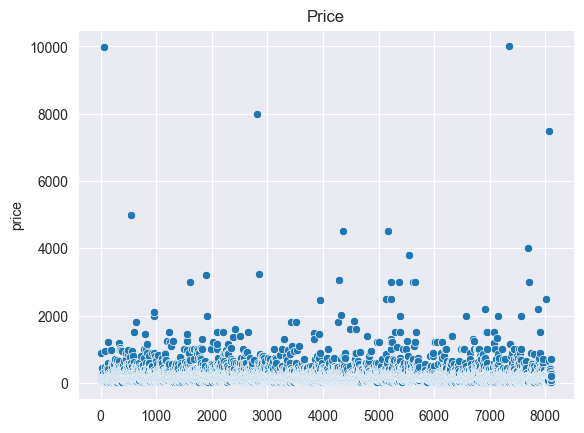

In [639]:
# Plotting price against index
sns.scatterplot(x=df.index, y=df['price']).set(title='Price')

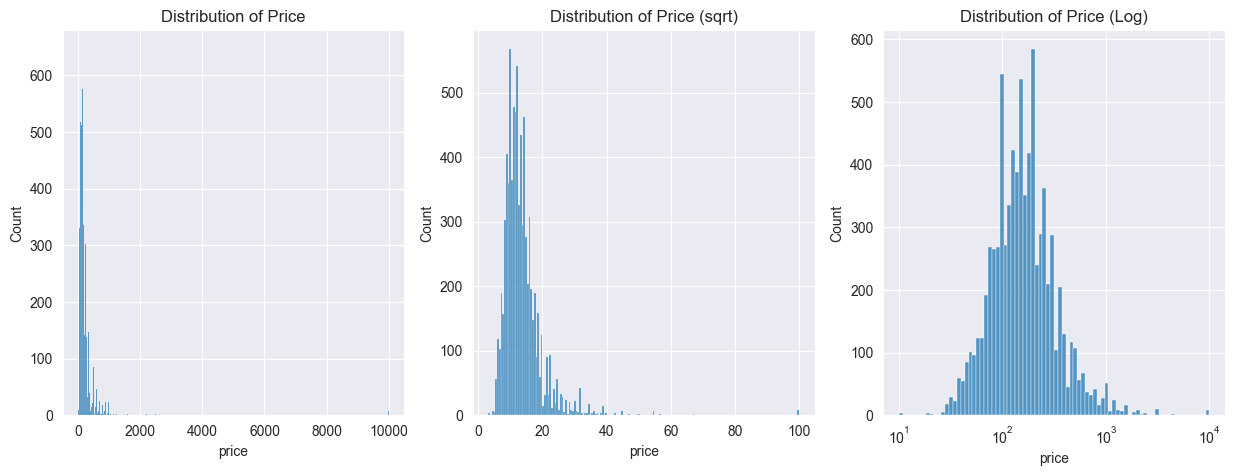

In [640]:
# Plotting histogram of price
fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.histplot(df['price'], ax=ax[0]).set(title='Distribution of Price')
sns.histplot(np.sqrt(df['price']), ax=ax[1]).set(title='Distribution of Price (sqrt)')
sns.histplot(df['price'], log_scale=True, ax=ax[2]).set(title='Distribution of Price (Log)')
plt.show()

In [641]:
# Changing scale of price to log
df['price'] = np.log(df['price'])

### Numeric Variables - Latitude, Longitude, Bathrooms, Bedroom, Minimum Nights, Price

We will look at the numeric variables looking at a heatmap of the correlation of numeric variables. It looks like there is a moderately strong positive correlation between log scale price and bedrooms. There is a mild positive correlation between latitude and log scale price. All other variables have very weak relationships with the price. 

[Text(0.5, 1.0, 'Correlation Heatmap of Numeric Variables')]

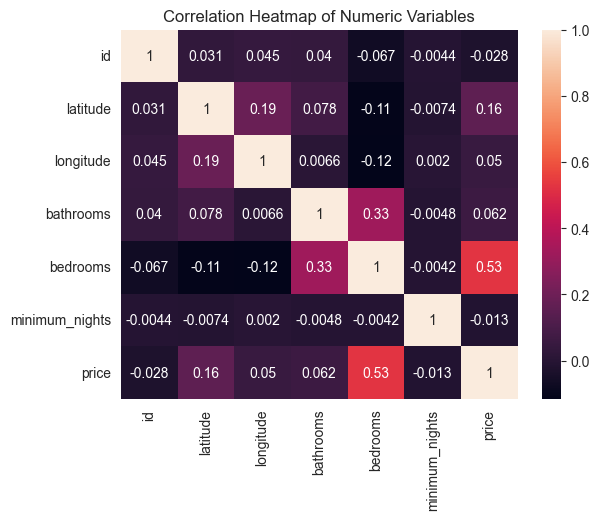

In [642]:
sns.heatmap(df.corr(), annot=True).set(title='Correlation Heatmap of Numeric Variables')

### Distribution of Bedroom Variable

Checking distribution of number of bedrooms, since it is the most correlated numerical variable. The data is left skewed.

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

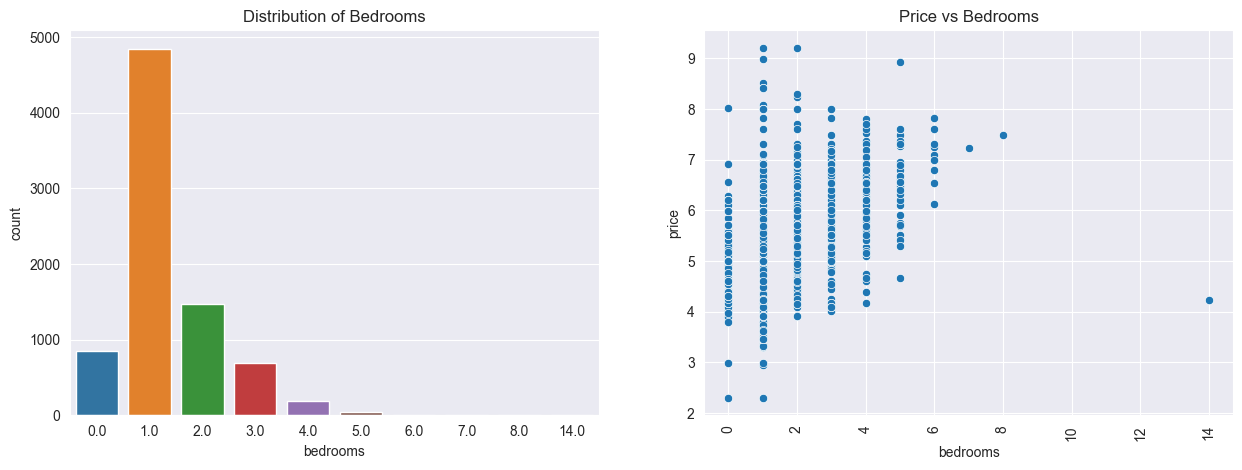

In [643]:
# Countplot of bedroom variable
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(df['bedrooms'], ax=ax[0]).set(title='Distribution of Bedrooms')
sns.scatterplot(x=df['bedrooms'], y=df['price'], ax=ax[1]).set(title='Price vs Bedrooms')
plt.xticks(rotation=90)

### Relationship of Latitude, Longitude, Bathrooms, Minimum Nights and Price

Since a linear relationship between latitude, longitude, bathrooms and minimum nights with price was unable to be found using the heatmap, I am going to plot each variable against price to search for any undiscovered relationships. Latitude and longitude variables have no visable correlation with price. There is clustering in the bathrooms and minimum nights data but no change is needed as it is already formatted as an ordinal variable. 

[Text(0.5, 1.0, 'Latitude vs Longitude')]

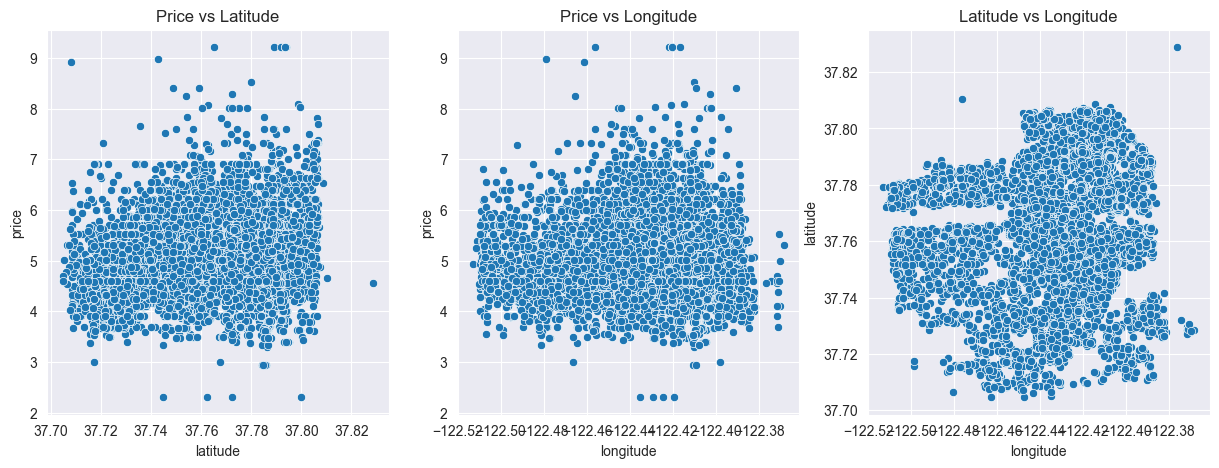

In [644]:
# Plotting relationship of Latitude and Longitude
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.scatterplot(x=df['latitude'], y=df['price'], ax=ax[0]).set(title='Price vs Latitude')
sns.scatterplot(x=df['longitude'], y=df['price'], ax=ax[1]).set(title='Price vs Longitude')
sns.scatterplot(x=df['longitude'], y=df['latitude'], ax=ax[2]).set(title='Latitude vs Longitude')

[Text(0.5, 1.0, 'Price vs Minimum Nights')]

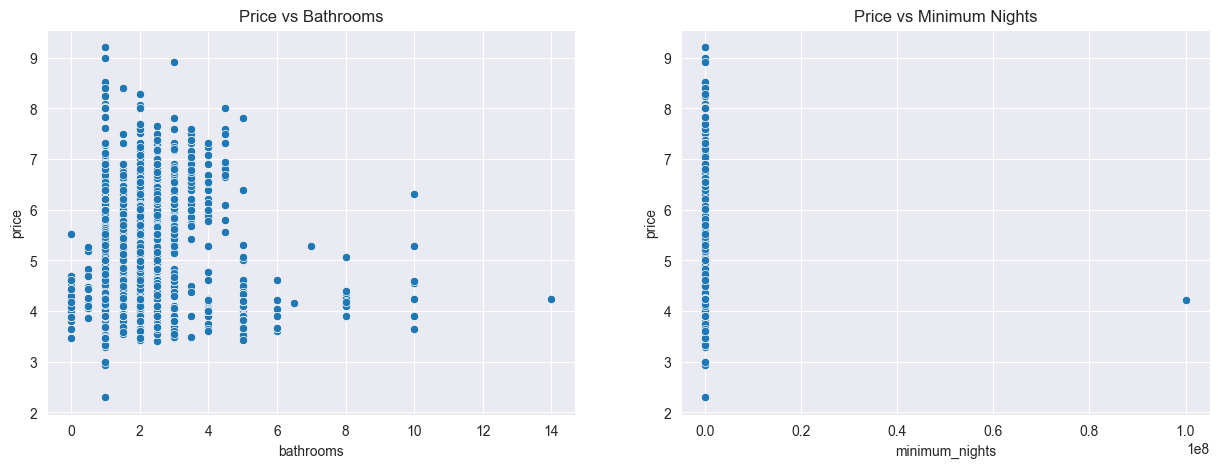

In [645]:
# Plotting relationship of bathrooms and minimum nights
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(x=df['bathrooms'], y=df['price'], ax=ax[0]).set(title='Price vs Bathrooms')
sns.scatterplot(x=df['minimum_nights'], y=df['price'], ax=ax[1]).set(title='Price vs Minimum Nights')

<AxesSubplot:xlabel='minimum_nights', ylabel='price'>

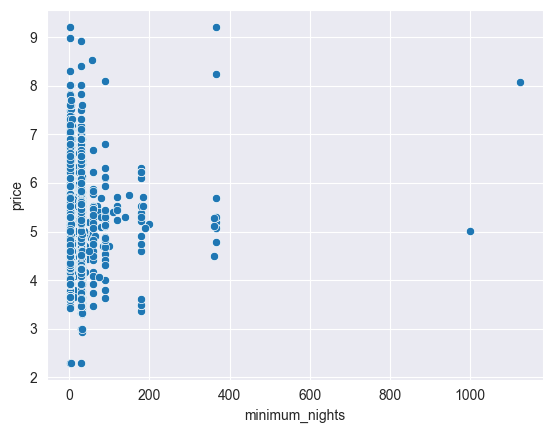

In [646]:
# Removing outlier in minimum nights column
min_nights = df[['price', 'minimum_nights']]
mask = min_nights[min_nights['minimum_nights'] != np.max(min_nights['minimum_nights'])]
sns.scatterplot(x=mask['minimum_nights'],y=mask['price'])

### Using KNN to group Latitude and Longitude

Latitude and longitude can be important determinants for pricing due to geographic location and price changes for locations. I elected to use a KMeans regression model to group by geographical location and use those labels in the model.

In [647]:
from sklearn.cluster import KMeans

# Creating KMeans Object
knn = KMeans(init='random', n_clusters=20, n_init=10, max_iter=300, random_state=random_state)
features = df[['longitude','latitude']]
knn.fit(features)

KMeans(init='random', n_clusters=20, random_state=23)

In [648]:
# Creating new dataframe for label variables
labels = knn.labels_
df['loc_labels'] = labels

print(df['loc_labels'].value_counts())

10    881
5     677
0     574
2     523
11    521
3     503
15    497
13    456
18    437
8     374
14    367
19    341
17    325
16    302
9     275
12    263
6     238
7     190
4     185
1     182
Name: loc_labels, dtype: int64


[Text(0.5, 1.0, 'Latitude vs Longitude (Labeled)')]

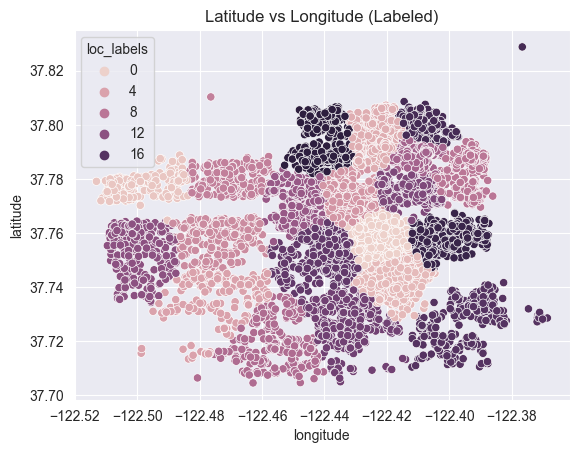

In [649]:
# Visualizing Clustering
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['loc_labels']).set(title='Latitude vs Longitude (Labeled)')

### Categorical Variables - Property Type, Room Type

We will plot the distributions of the categorical variables and their correlation with price. There is a distribution of price accordingly with each categorical variable value. The distributions of property type and room type are moderately left skewed. There are visable fluctuations in price depending on both categorical variables. 

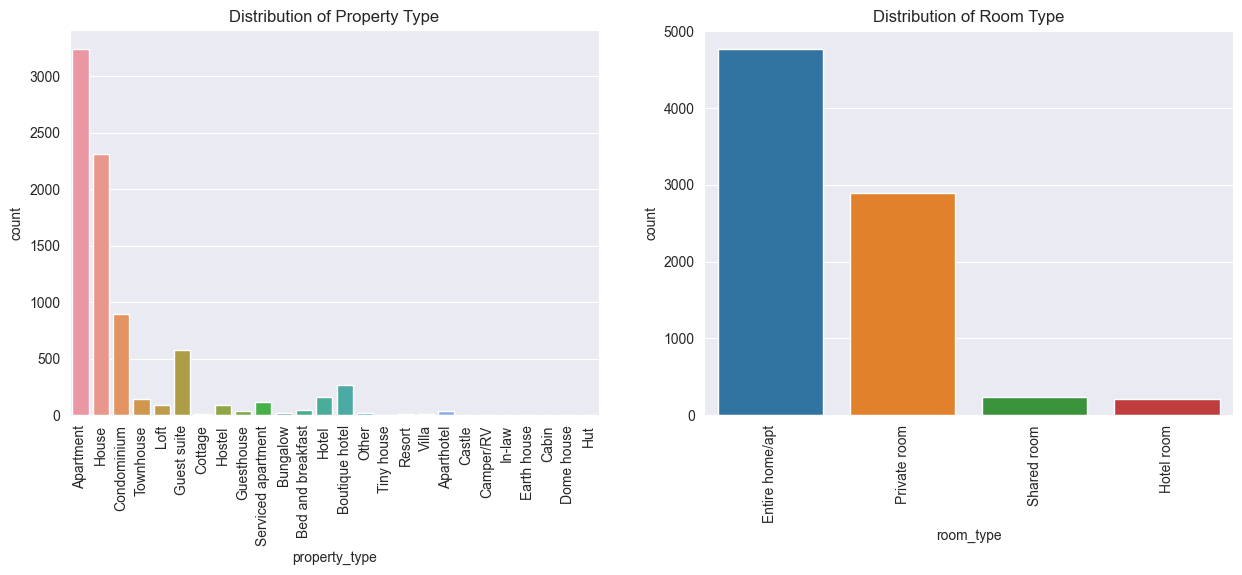

In [650]:
# Distribution of categorical variables
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(df['property_type'], ax=ax[0]).set(title='Distribution of Property Type')
sns.countplot(df['room_type'], ax=ax[1]).set(title='Distribution of Room Type')
for axes in fig.axes:
    plt.sca(axes)
    plt.xticks(rotation=90)

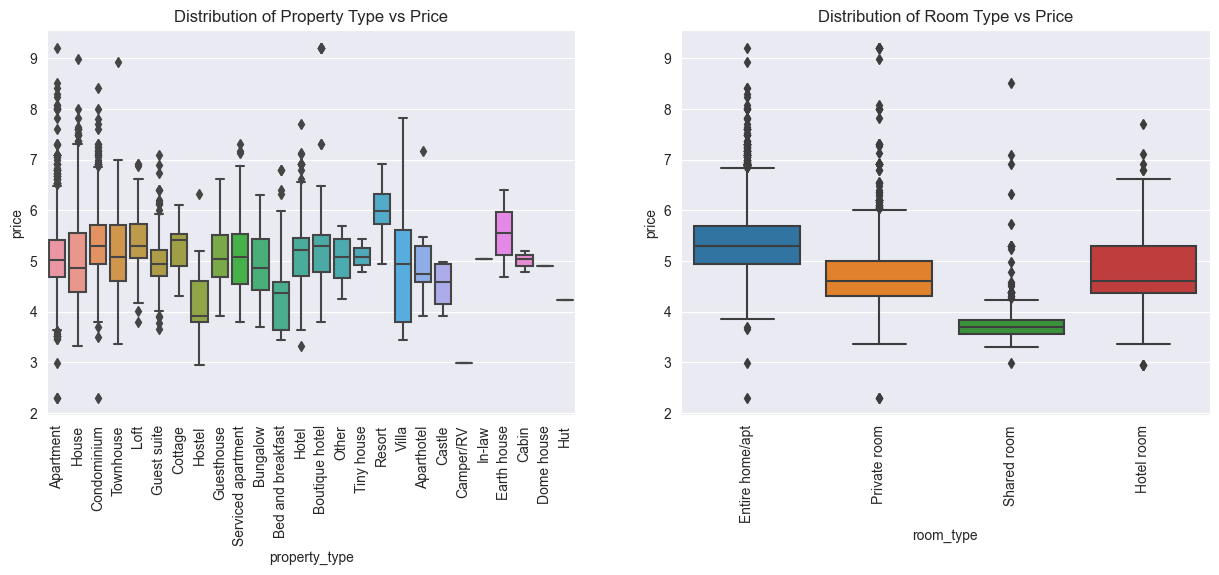

In [651]:
# Categorical variabels vs price
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(data=df, x='property_type', y='price', ax=ax[0]).set(title='Distribution of Property Type vs Price')
sns.boxplot(data=df, x='room_type', y='price', ax=ax[1]).set(title='Distribution of Room Type vs Price')
for axes in fig.axes:
    plt.sca(axes)
    plt.xticks(rotation=90)

# Model Fitting and Evaluation

Predicting price is considered to be a regression machine learning problem. I am electing to use a simple Linear Regression and Lasso Regression. Linear Regression was choosen because of the the moderate correlation between bedrooms and price. Lasos Regression was choosen because it will minimize the amount of features used since there is only a single variable with moderate-high correlation.

The comparison model being used is the Decision Tree Regression Model due to the it's ease of interpreting data with independence from outliers. Several columns in the dataset have outliers. 

R squared and RMSE (Root Mean Squared Error) are chosen to evaluate the model. R squared measures the fit on dependent variables. RMSE measures the deviation between predicted results and the actual.

### Preparing Categorical Data for Modeling

For modeling, we have selected property type, room type, bedrooms, bathrooms, and minimum nights as our feature variables and price as our target variable. Before modeling, we need to make sure that categorical variables have been encoded for regression and numerical variables have been scaled for skew. 

In [652]:
# Encoding Categorical Variables
lb = LabelEncoder()
df['property_type'] = lb.fit_transform(df['property_type'])
df['room_type'] = lb.fit_transform(df['room_type'])

In [653]:
# Normalizing bedrooms variable
scaler = PowerTransformer()
df[['bedrooms', 'bathrooms', 'minimum_nights']] = scaler.fit_transform(df[['bedrooms', 'bathrooms', 'minimum_nights']])

In [654]:
# Creating feature and target datasets
feature_cols = ['loc_labels','property_type','room_type','bedrooms','bathrooms','minimum_nights']
X=df[feature_cols]
y=df['price']

In [655]:
# Creating training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_state)

### Linear Regression Model

In [656]:
# Initializing and Fitting Linear Regression Model
lr = LinearRegression()

# Fit
lr.fit(X_train, y_train)

# Printing training accuracy
print('Training Accuracy: {}'.format(lr.score(X_train, y_train)))

Training Accuracy: 0.4544467226197656


In [657]:
# Predicting Linear Regression Model
y_pred = lr.predict(X_test)
print('Linear Regression r2_score: {}'.format(r2_score(y_test,y_pred)))
print('Linear Regression Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(y_test,y_pred))))

Linear Regression r2_score: 0.4165496746505304
Linear Regression Root Mean Squared Error: 0.5591958495035613


### Feature Importance

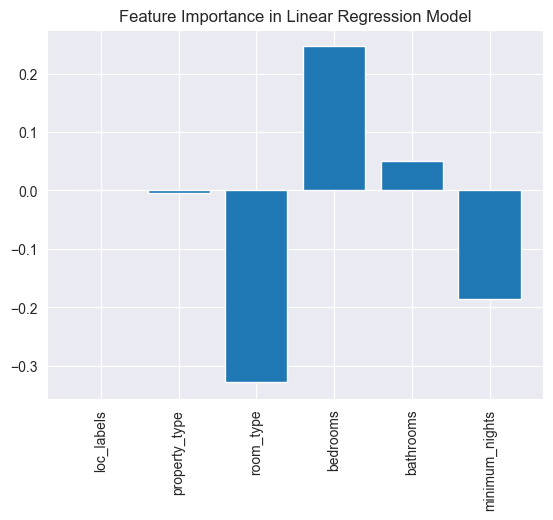

In [658]:
# Feature importance of Linear Regression
feature_imp = {}
for i in range(len(feature_cols)):
    feature_imp[feature_cols[i]] = lr.coef_[i]
    
plt.bar(feature_imp.keys(), feature_imp.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Linear Regression Model');

### Lasso Regression Model

In [659]:
# Creating Lasso Regression Model
lasso = Lasso(alpha=0.001)

# Fitting Lasso Model
lasso.fit(X_train, y_train)

Lasso(alpha=0.001)

In [660]:
# Predicting and accuracy
pred_4 = lasso.predict(X_test)
print('Lasso R-squared: {}'.format(r2_score(y_test,pred_4)))
print('Lasso Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(y_test,pred_4))))

Lasso R-squared: 0.41657699340017773
Lasso Root Mean Squared Error: 0.5591827578061371


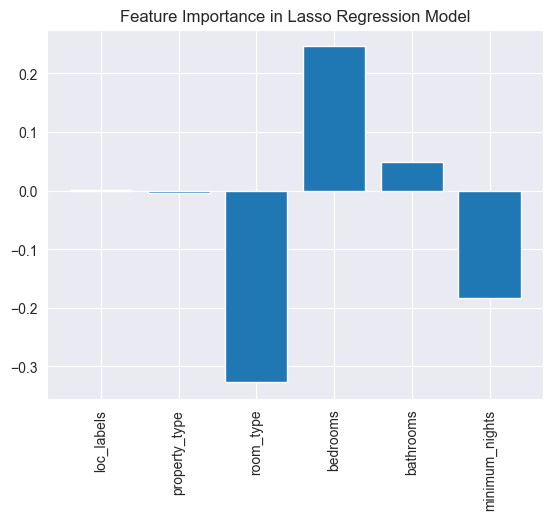

In [661]:
# Feature importance of Lasso Regression
feature_imp = {}
for i in range(len(feature_cols)):
    feature_imp[feature_cols[i]] = lasso.coef_[i]
    
plt.bar(feature_imp.keys(), feature_imp.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Lasso Regression Model');

### Decision Tree Regression Model

In [662]:
# Creating Decision Tree Regressor 
dtr = DecisionTreeRegressor(random_state=random_state)

# Fit
dtr.fit(X_train, y_train)

# Printing training accuracy
print('Training Accuracy: {}'.format(dtr.score(X_train, y_train)))

Training Accuracy: 0.8529286429914369


In [663]:
# Predicting and accuracy
y_pred2 = dtr.predict(X_test)
print('Decision Tree R-squared: {}'.format(r2_score(y_test,y_pred2)))
print('Decision Tree Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(y_test,y_pred2))))

Decision Tree R-squared: 0.5179545328098804
Decision Tree Root Mean Squared Error: 0.508283483685021


Text(0.5, 1.0, 'Feature Importance in Decision Tree Regression Model')

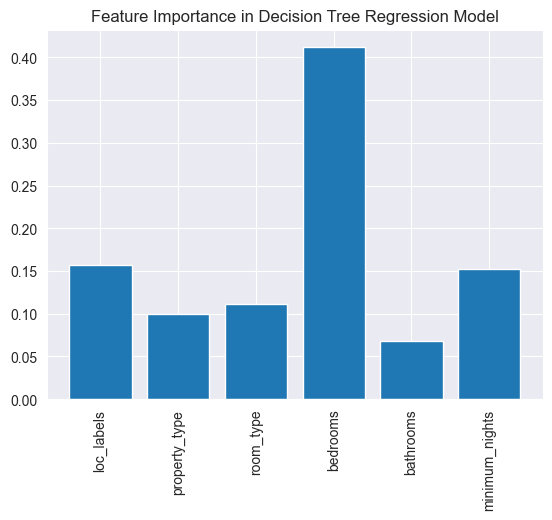

In [664]:
# Plotting feature importance
importance = dtr.feature_importances_

tree_importance = {}
for i in range(len(feature_cols)):
    tree_importance[feature_cols[i]] = importance[i]
    
plt.bar(tree_importance.keys(), tree_importance.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Decision Tree Regression Model')

### Hyperparameter Tuning

In [665]:
# Creating DecisionTreeRegressor
dtr_tuning = DecisionTreeRegressor()

# Setting paramater distribution
param_dist = {'splitter':('best','random'),
              'max_depth':np.arange(10,20),
              'max_features':np.arange(1,5),
              'min_samples_split':np.arange(1,5)}

# Setting up KFold
kf = KFold(n_splits=10)

# Setting up GridSearchCV
grid_dtr = GridSearchCV(dtr_tuning, param_dist, scoring='neg_mean_squared_error', cv=kf)

In [666]:
# Fitting GridSearchCV
grid_dtr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'max_features': array([1, 2, 3, 4]),
                         'min_samples_split': array([1, 2, 3, 4]),
                         'splitter': ('best', 'random')},
             scoring='neg_mean_squared_error')

In [667]:
# Best Params and Scaore
print('Best Params: {}'.format(grid_dtr.best_params_))
print('Accuracy Score: {}'.format(grid_dtr.best_score_))

Best Params: {'max_depth': 16, 'max_features': 4, 'min_samples_split': 4, 'splitter': 'random'}
Accuracy Score: -0.22614513985247015


### Applying Tuning Paramaters

In [668]:
# Creating Tuned Decision Tree
dtr_tuned = DecisionTreeRegressor(max_depth=16, max_features=4, min_samples_split=4, splitter='random', random_state=random_state)

In [669]:
# Fitting
dtr_tuned.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=16, max_features=4, min_samples_split=4,
                      random_state=23, splitter='random')

In [670]:
# Predicting and accuracy
y_pred3 = dtr_tuned.predict(X_test)
print('Decision Tree R-squared: {}'.format(r2_score(y_test,y_pred3)))
print('Decision Tree Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(y_test,y_pred3))))

Decision Tree R-squared: 0.5350335782053448
Decision Tree Root Mean Squared Error: 0.49919794808483486


Text(0.5, 1.0, 'Feature Importance in Tuned Decision Tree Regression Model')

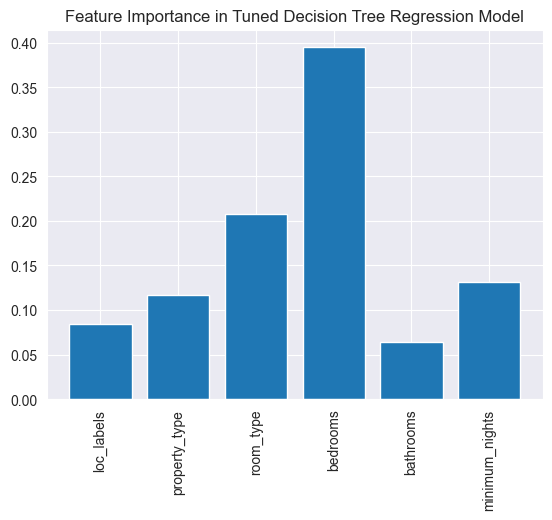

In [671]:
# Plotting feature importance
importance = dtr_tuned.feature_importances_

tree_importance = {}
for i in range(len(feature_cols)):
    tree_importance[feature_cols[i]] = importance[i]
    
plt.bar(tree_importance.keys(), tree_importance.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Tuned Decision Tree Regression Model')

# Results

The R squared of Linear Regression, Lasso Regression, Decision Tree Regression, and Tuned Decision Tree Regression are 0.42, 0.42, 0.52 and 0.54 respectively. This shows that the Tuned Decision Tree Regression model fits the features better. The RMSE of Linear Regression, Lasso Regression, Decision Tree Regression, and Tuned Decision Tree Regression are 0.56, 0.56, 0.51 and 0.50. This shows that the Tuned Decision Tree Regression model has the least error in predicting values. 

### Evaluating Business Criteria

The company wants to avoid price estimations that are less than 25 dollars difference from the actual price, to avoid discouraging people to use their platform. We would consider utilizing percentage predictions from each model where the prediction is within a 25 dollar range with the actual price. This will be used as a KPI to compre the 4 models again. The higher the percentage of good price predictions, the better the model performs. The percentages of good predictions from Linear Regression, Lasso Regression, Decision Tree Regression, and Tuned Decision Tree Regression are 31.8%, 31.8%, 42.9% and 40.3% respectively.    

### Linear Regression 

In [672]:
# Creating DataFrame with actual and predicted values
# Need to scale values from log
eval_df = pd.DataFrame()
eval_df['actual'] = np.round(np.exp(y_test), 1)
eval_df['linear'] = np.round(np.exp(y_pred), 1)

Text(0.5, 1.0, 'Price Evaluation by Linear Regression Model')

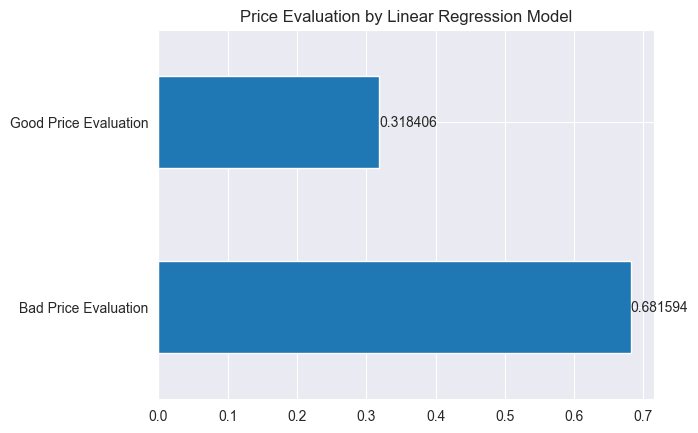

In [673]:
# Checking Linear Regression Predictions for Criteria
eval_df['diff_1'] = abs(eval_df['linear']-eval_df['actual'])
eval_df['eval_1'] = eval_df['diff_1'].apply(lambda x: 'Good Price Evaluation' if x < 25 else 'Bad Price Evaluation')

# Plotting Results
ax = eval_df['eval_1'].value_counts(normalize=True).plot.barh()
ax.bar_label(ax.containers[0])
ax.set_title('Price Evaluation by Linear Regression Model')

In [674]:
print(eval_df.head())

      actual  linear  diff_1                 eval_1
1352   120.0   114.6     5.4  Good Price Evaluation
3150   189.0   164.3    24.7  Good Price Evaluation
28     150.0   101.3    48.7   Bad Price Evaluation
6472   100.0   170.7    70.7   Bad Price Evaluation
5264   575.0   305.5   269.5   Bad Price Evaluation


### Lasso Regression

In [675]:
# Adding predicted values to DataFrame
eval_df['lasso'] = np.round(np.exp(pred_4), 1)

Text(0.5, 1.0, 'Price Evaluation by Lasso Regression Model')

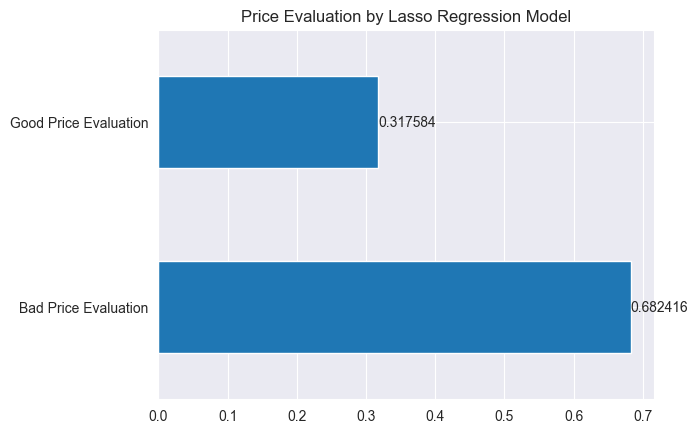

In [676]:
# Checking Lasso Regression Predictions for Criteria
eval_df['diff_2'] = abs(eval_df['lasso']-eval_df['actual'])
eval_df['eval_2'] = eval_df['diff_2'].apply(lambda x: 'Good Price Evaluation' if x < 25 else 'Bad Price Evaluation')

# Plotting Results
ax = eval_df['eval_2'].value_counts(normalize=True).plot.barh()
ax.bar_label(ax.containers[0])
ax.set_title('Price Evaluation by Lasso Regression Model')

### Decision Tree

In [677]:
# Adding predicted values to DataFrame
eval_df['dtr'] = np.round(np.exp(y_pred2), 1)

Text(0.5, 1.0, 'Price Evaluation by Decision Tree Model Regression Model')

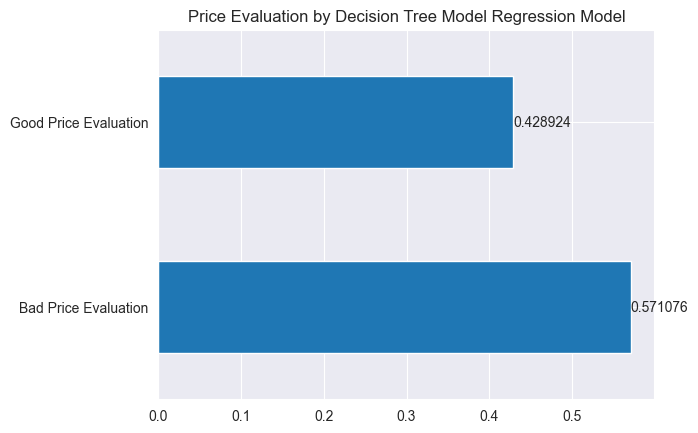

In [681]:
# Checking Decision Tree Regression Predictions for Criteria
eval_df['diff_3'] = abs(eval_df['dtr']-eval_df['actual'])
eval_df['eval_3'] = eval_df['diff_3'].apply(lambda x: 'Good Price Evaluation' if x < 25 else 'Bad Price Evaluation')

# Plotting Results
ax = eval_df['eval_3'].value_counts(normalize=True).plot.barh()
ax.bar_label(ax.containers[0])
ax.set_title('Price Evaluation by Decision Tree Model Regression Model')

### Tuned Decision Tree

In [679]:
# Adding predicted values to DataFrame
eval_df['dtr_tuned'] = np.round(np.exp(y_pred3), 1)

Text(0.5, 1.0, 'Price Evaluation by Tune Decision Tree Regression Model')

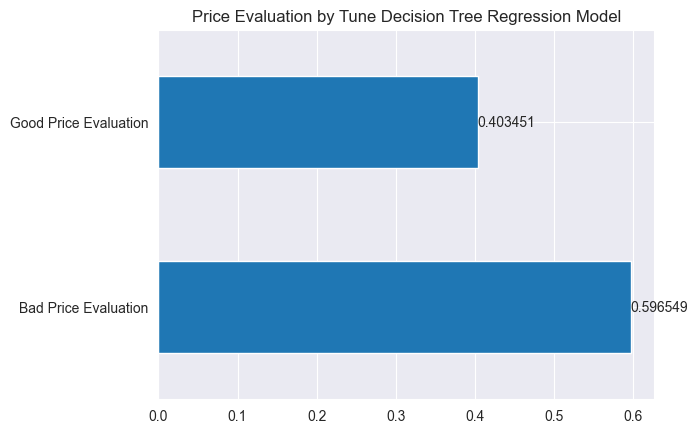

In [682]:
# Checking Tuned Decision Tree Regression Predictions for Criteria
eval_df['diff_4'] = abs(eval_df['dtr_tuned']-eval_df['actual'])
eval_df['eval_4'] = eval_df['diff_4'].apply(lambda x: 'Good Price Evaluation' if x < 25 else 'Bad Price Evaluation')

# Plotting Results
ax = eval_df['eval_4'].value_counts(normalize=True).plot.barh()
ax.bar_label(ax.containers[0])
ax.set_title('Price Evaluation by Tune Decision Tree Regression Model')

### Recommendations

To help the product manager, we would deploy the Decision Tree Regrssion model into production. By implementing this model, about 43% of renting prices could be predicted within marginal error. This will help individuals choose appropriate rates for their rental properties. 

To better evaluate whether this model can really help predict rental prices, I would suggest testing the model against new properties.

To implement and improve the model, I would consider the following steps:
- Obtain more data points. From the currently dataset, it is hard to interpret any strong relationships that could be used to predict price. The only relationship with moderate correlation is bedroom count. 
- Feature Engineering to either reduce the categories in the model or create more meaningful features for the model. The latitude and longitude columns didn't provide any significant data, possible zip codes or strong correlative location statistics may be more helpful in this case. 